In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from scipy.signal import find_peaks
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

In [2]:
train_len = 36481
valid_len = 7817
window_len = 12 + 12 # 12 for history | 12 for future

# start_ts = datetime.fromisoformat('20170101T00:00:00')
start_ts = datetime.strptime('20170101T00:00:00', '%Y%m%dT%H:%M:%S')
timestamps = [start_ts + timedelta(minutes = 5 * train_len) + timedelta(minutes = 5 * i) for i in range(valid_len - window_len)]

In [3]:
# data_folder = '../../logs/2025-02-26_11-36-36_pems-bay_pred-60min_his-60min_centralized_analysis-neighbours-and-no-neighbours/val_metric'
data_folder = '../../logs/2025-09-30_11-38-36_pems-bay_pred-60min_his-60min_centralized_analysis-neighbours-and-no-neighbours/val_metric'
arr_A = np.genfromtxt(f'{data_folder}/d_original.csv', delimiter=',').T
arr_B = np.genfromtxt(f'{data_folder}/d_no_neighbours.csv', delimiter=',').T
arr_y = np.genfromtxt('../../data/pems-bay/vel.csv', delimiter=',', skip_header = train_len+window_len-1, max_rows = valid_len-window_len).T
arr_A.shape, arr_B.shape, arr_y.shape

((325, 7793), (325, 7793), (325, 7793))

In [4]:
df = pd.DataFrame(arr_y).melt(var_name = 'timestep', value_name = 'y', ignore_index = False)
df['err_graph'] = pd.DataFrame(arr_A).melt().value
df['err_local'] = pd.DataFrame(arr_B).melt().value
df = df.reset_index(names = 'sensor')
df['timestamp'] = start_ts + timedelta(minutes=5 * train_len) + pd.to_timedelta(df.timestep * 5, unit='m')
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

df_A = pd.DataFrame(arr_A, columns = timestamps).rename_axis(index = 'sensor')
df_B = pd.DataFrame(arr_B, columns = timestamps).rename_axis(index = 'sensor')

In [5]:
selected_sensors = [133, 134, 320, 74, 283]
selected_sensors = [134]

subset_df_A = df_A.loc[selected_sensors]
subset_df_B = df_B.loc[selected_sensors]
subset_df = df[df['sensor'].isin(selected_sensors)]
df_y = pd.DataFrame(arr_y, columns=timestamps).rename_axis(index='sensor')

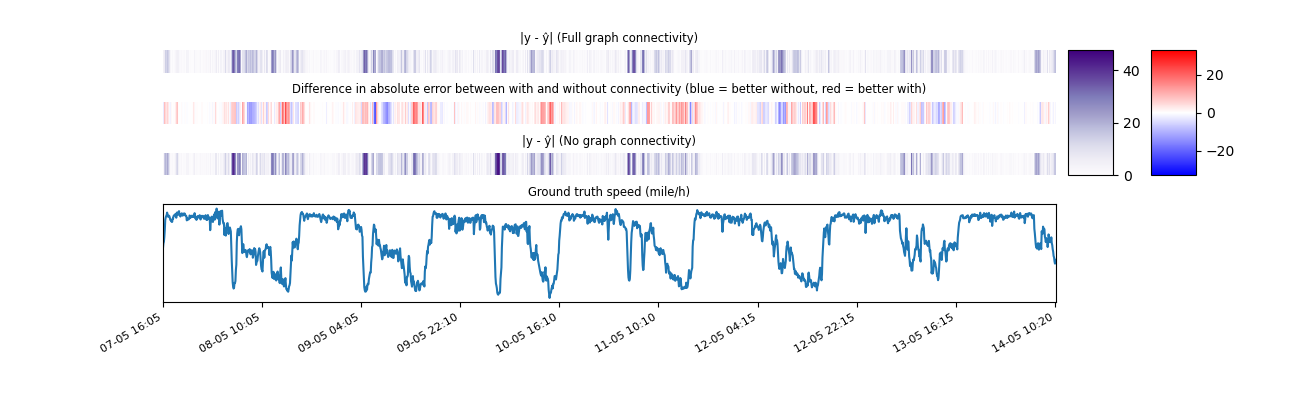

In [13]:
# ----- shared scales -----
abs_vmax = float(np.nanmax([np.nanmax(subset_df_A.values), np.nanmax(subset_df_B.values)]))
diff_mat = subset_df_B - subset_df_A
diff_abs_max = float(np.nanmax(np.abs(diff_mat.values)))

# Two separate scales
# For subplots 1 & 3: white to another color (absolute errors)
norm_abs = mcolors.Normalize(vmin=0, vmax=abs_vmax)
cmap_abs = 'Purples'  # Try these: 'viridis', 'Blues', 'Greens', 'Purples', 'coolwarm'

# For subplot 2: blue-white-red (differences)
norm_diff = TwoSlopeNorm(vcenter=0.0, vmin=-diff_abs_max, vmax=diff_abs_max)
cmap_diff = 'bwr'

# ===== show FIRST 25% (contiguous window) =====
N = len(timestamps)
w = max(1, N // 4)                 # window length = first quarter
keep_idx  = np.arange(w)           # 0 .. w-1
keep_cols = [timestamps[i] for i in keep_idx]

# filter matrices for heatmaps
subset_df_A_s = subset_df_A[keep_cols]
subset_df_B_s = subset_df_B[keep_cols]
diff_mat_s    = subset_df_B_s - subset_df_A_s

# filter the line data to the same window
subset_df_s = subset_df[subset_df['timestep'].isin(keep_idx)].copy()

# ===== PLOT with two colorbars =====
fig = plt.figure(figsize=(13, 4.2))  # Slightly wider for better spacing
gs = fig.add_gridspec(
    nrows=4, ncols=4,  # Changed to 4 columns for better spacing
    width_ratios=[20, 1, 0.3, 1],  # Main plot, colorbar1, spacing, colorbar2
    height_ratios=[0.05, 0.05, 0.05, 0.22],
    wspace=0.05, hspace=0.7
)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[3, 0])
cax_abs = fig.add_subplot(gs[0:3, 1])   # Colorbar for abs errors - same height as diff
cax_diff = fig.add_subplot(gs[0:3, 3])  # Colorbar for differences - same height

ax1.set_title('|y - ŷ| (Full graph connectivity)', size='small')
sns.heatmap(subset_df_A_s, cmap=cmap_abs, norm=norm_abs,
            ax=ax1, cbar=False, xticklabels=False, yticklabels=False, rasterized=True)

ax2.set_title('Difference in absolute error between with and without connectivity (blue = better without, red = better with)', size='small')
sns.heatmap(diff_mat_s, cmap=cmap_diff, norm=norm_diff,
            ax=ax2, cbar=False, xticklabels=False, yticklabels=False, rasterized=True)

ax3.set_title('|y - ŷ| (No graph connectivity)', size='small')
sns.heatmap(subset_df_B_s, cmap=cmap_abs, norm=norm_abs,
            ax=ax3, cbar=False, xticklabels=False, yticklabels=False, rasterized=True)

# Create two separate colorbars
mappable_abs = ScalarMappable(norm=norm_abs, cmap=cmap_abs)
mappable_abs.set_array([])
cbar_abs = fig.colorbar(mappable_abs, cax=cax_abs)
# cbar_abs.set_label('Absolute Error', size=9)

mappable_diff = ScalarMappable(norm=norm_diff, cmap=cmap_diff)
mappable_diff.set_array([])
cbar_diff = fig.colorbar(mappable_diff, cax=cax_diff)
# cbar_diff.set_label('Difference', size=9)

ax4.set_title('Ground truth speed (mile/h)', size='small')
sns.lineplot(subset_df_s, x='timestep', y='y', errorbar=('pi', 90), ax=ax4)

# ----- tidy x ticks for the reduced window -----
n_cols = w
ax4.set_xlim(0, n_cols)  # match reduced length

# choose up to ~10 nicely spaced ticks
num_ticks = min(10, n_cols)
tick_locs = np.linspace(0, n_cols - 1, num_ticks, dtype=int)
tick_labels = [keep_cols[i].strftime('%d-%m %H:%M') for i in tick_locs]

ax4.set_xticks(tick_locs)
ax4.set_xticklabels(tick_labels, rotation=30, ha='right', fontsize=8)
ax4.set_xlabel('')  # no 'timestep' label

# ----- clean up y-axis and prevent cut-off of x labels -----
for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylabel('')
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)

fig.subplots_adjust(bottom=0.28, right=0.92)  # Adjusted right margin

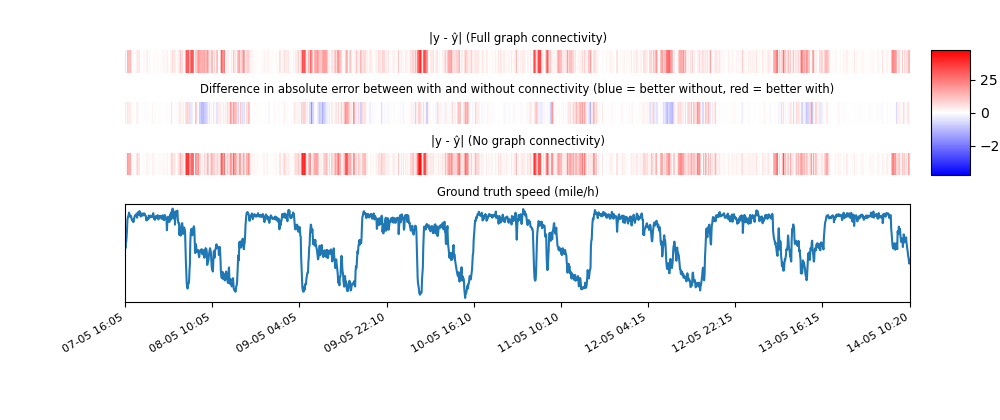

In [12]:
# ----- shared scales -----
abs_vmax = float(np.nanmax([np.nanmax(subset_df_A.values), np.nanmax(subset_df_B.values)]))
diff_mat = subset_df_B - subset_df_A
diff_abs_max = float(np.nanmax(np.abs(diff_mat.values)))

# one symmetric scale for all three heatmaps
vmax_shared = max(abs_vmax, diff_abs_max)
norm_shared = TwoSlopeNorm(vcenter=0.0, vmin=-vmax_shared, vmax=vmax_shared)
cmap_shared = 'bwr'

# ===== show FIRST 25% (contiguous window) =====
N = len(timestamps)
w = max(1, N // 4)                 # window length = first quarter
keep_idx  = np.arange(w)           # 0 .. w-1
keep_cols = [timestamps[i] for i in keep_idx]

# filter matrices for heatmaps
subset_df_A_s = subset_df_A[keep_cols]
subset_df_B_s = subset_df_B[keep_cols]
diff_mat_s    = subset_df_B_s - subset_df_A_s

# filter the line data to the same window
subset_df_s = subset_df[subset_df['timestep'].isin(keep_idx)].copy()

# (optional) keep your original norm_shared for comparability,
# or recompute on the reduced data. Here we KEEP the original norm_shared.

# ===== PLOT using *_s data =====
fig = plt.figure(figsize=(10, 4.2))
gs = fig.add_gridspec(
    nrows=4, ncols=2,
    width_ratios=[20, 1],
    height_ratios=[0.05, 0.05, 0.05, 0.22],
    wspace=0.05, hspace=0.7
)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[3, 0])
cax = fig.add_subplot(gs[0:3, 1])

ax1.set_title('|y - ŷ| (Full graph connectivity)', size='small')
sns.heatmap(subset_df_A_s, cmap=cmap_shared, norm=norm_shared,
            ax=ax1, cbar=False, xticklabels=False, yticklabels=False, rasterized=True)

ax2.set_title('Difference in absolute error between with and without connectivity (blue = better without, red = better with)', size='small')
sns.heatmap(diff_mat_s, cmap=cmap_shared, norm=norm_shared,
            ax=ax2, cbar=False, xticklabels=False, yticklabels=False, rasterized=True)

ax3.set_title('|y - ŷ| (No graph connectivity)', size='small')
sns.heatmap(subset_df_B_s, cmap=cmap_shared, norm=norm_shared,
            ax=ax3, cbar=False, xticklabels=False, yticklabels=False, rasterized=True)

mappable = ScalarMappable(norm=norm_shared, cmap=cmap_shared); mappable.set_array([])
fig.colorbar(mappable, cax=cax)

ax4.set_title('Ground truth speed (mile/h)', size='small')
sns.lineplot(subset_df_s, x='timestep', y='y', errorbar=('pi', 90), ax=ax4)

# ----- tidy x ticks for the reduced window -----
n_cols = w
ax4.set_xlim(0, n_cols)  # match reduced length

# choose up to ~10 nicely spaced ticks
num_ticks = min(10, n_cols)
tick_locs = np.linspace(0, n_cols - 1, num_ticks, dtype=int)
tick_labels = [keep_cols[i].strftime('%d-%m %H:%M') for i in tick_locs]

ax4.set_xticks(tick_locs)
ax4.set_xticklabels(tick_labels, rotation=30, ha='right', fontsize=8)
ax4.set_xlabel('')  # no 'timestep' label

# ----- clean up y-axis and prevent cut-off of x labels -----
for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylabel('')
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)

fig.subplots_adjust(bottom=0.28, right=0.97)  # more bottom room for rotated labels

()

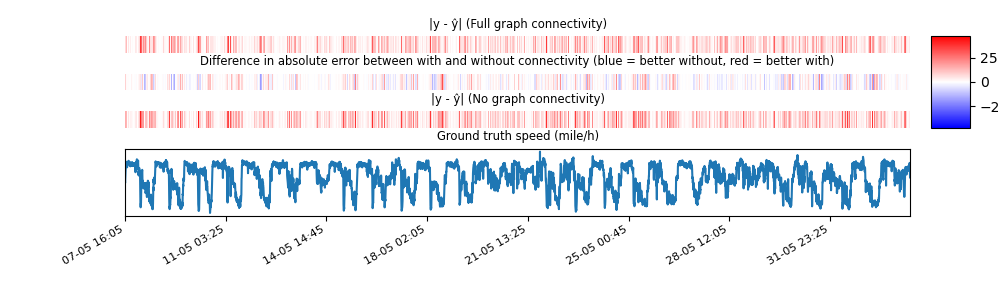

In [ ]:


df_y = pd.DataFrame(arr_y, columns=timestamps).rename_axis(index='sensor')

# ----- shared scales -----
abs_vmax = float(np.nanmax([np.nanmax(subset_df_A.values), np.nanmax(subset_df_B.values)]))
diff_mat = subset_df_B - subset_df_A
diff_abs_max = float(np.nanmax(np.abs(diff_mat.values)))

# one symmetric scale for all three heatmaps
vmax_shared = max(abs_vmax, diff_abs_max)
norm_shared = TwoSlopeNorm(vcenter=0.0, vmin=-vmax_shared, vmax=vmax_shared)
cmap_shared = 'bwr'

fig = plt.figure(figsize=(10, 3))
gs = fig.add_gridspec(
    nrows=4, ncols=2,
    width_ratios=[20, 1],                    # narrow column for colorbar
    height_ratios=[0.05, 0.05, 0.05, 0.2],      # shorter heatmaps, taller line plot
    wspace=0.05, hspace=0.7
)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)
ax4 = fig.add_subplot(gs[3, 0])

# colorbar axis spans first three rows
cax = fig.add_subplot(gs[0:3, 1])

ax1.set_title('|y - ŷ| (Full graph connectivity)', size = 'small')
hm1 = sns.heatmap(
    subset_df_A, cmap=cmap_shared, norm=norm_shared,
    ax=ax1, cbar=False, xticklabels=False, yticklabels=False, rasterized=True
)

ax2.set_title('Difference in absolute error between with and without connectivity (blue = better without, red = better with)', size = 'small')
hm2 = sns.heatmap(
    diff_mat, cmap=cmap_shared, norm=norm_shared,
    ax=ax2, cbar=False, xticklabels=False, yticklabels=False, rasterized=True
)

ax3.set_title('|y - ŷ| (No graph connectivity)', size = 'small')
hm3 = sns.heatmap(
    subset_df_B, cmap=cmap_shared, norm=norm_shared,
    ax=ax3, cbar=False, xticklabels=False, yticklabels=False, rasterized=True
)

# ----- single shared colorbar for 1–3 -----
mappable = ScalarMappable(norm=norm_shared, cmap=cmap_shared)
mappable.set_array([])  # required by mpl
cb = fig.colorbar(mappable, cax=cax)
# cb.set_label('Blue: no-graph better   ·   0   ·   Red: higher error / full-graph better', fontsize=8)

ax4.set_title('Ground truth speed (mile/h)', size='small')
sns.lineplot(subset_df, x = 'timestep', y = 'y', errorbar = ('pi', 90), ax = ax4)

# ----- tidy x ticks on bottom plot -----
target_labels = 10
n_cols = len(timestamps)
step = max(1, n_cols // target_labels)

tick_locs = ax4.get_xticks()
tick_idx = [int(round(x)) for x in tick_locs if 0 <= int(round(x)) < n_cols]
tick_labels = [timestamps[i].strftime('%d-%m %H:%M') for i in tick_idx]

ax4.set_xticks(tick_idx)
ax4.set_xticklabels(tick_labels, rotation=30, ha='right', fontsize=8)
ax4.tick_params(axis='x', pad=2)

ax4.set_xlim(0, n_cols) 

ax4.set_xlabel('') # Remove 'timestep' label

fig.subplots_adjust(bottom=0.28, right=0.97)

# ----- remove all y-axis labels/ticks -----
for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylabel('')
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)

# ax4.set_xticks(list(range(0, valid_len - window_len, 12*6)), [ts.strftime('%d-%m %H:%M') for ts in timestamps[::12*6]], rotation = 30, ha = 'right', size = 'small')
()

In [9]:
# ---- Config ----
sensor_id   = 134
prominence  = 20
time_window = 24          # ±24 steps around each dip
fmt         = '%d-%m %H:%M'

# Ensure datetime index
timestamps = pd.to_datetime(timestamps)
y = arr_y[sensor_id]

# ---- 1) Detect dips for this sensor ----
dip_idx, _ = find_peaks(-y, prominence=prominence)   # local minima
dip_times = timestamps[dip_idx]

# ---- 2) Build stats on full timeline: Δ = (NoGraph − WithGraph) ----
A = df_A.copy(); B = df_B.copy()
A.columns = pd.to_datetime(A.columns)
B.columns = pd.to_datetime(B.columns)

# Align to the full 'timestamps' so we can mask dips by index directly
with_series  = A.loc[sensor_id].reindex(timestamps)
without_series = B.loc[sensor_id].reindex(timestamps)
diff_full = (without_series - with_series)  # Δ > 0 ⇒ with-graph better

# Masks for dips vs non-dips (on the full timeline)
is_dip = pd.Series(False, index=timestamps)
is_dip.iloc[dip_idx] = True

diff_at_dips  = diff_full[is_dip].dropna()
diff_no_dips  = diff_full[~is_dip].dropna()

avg_at_dips   = diff_at_dips.mean()   if len(diff_at_dips)  else np.nan
avg_no_dips   = diff_no_dips.mean()   if len(diff_no_dips)  else np.nan
med_at_dips   = diff_at_dips.median() if len(diff_at_dips)  else np.nan
med_no_dips   = diff_no_dips.median() if len(diff_no_dips)  else np.nan

pct_with_better_at   = (diff_at_dips  > 0).mean()*100 if len(diff_at_dips)  else np.nan
pct_with_better_nond = (diff_no_dips  > 0).mean()*100 if len(diff_no_dips)  else np.nan

print(f"Sensor {sensor_id} — Δ|y−ŷ| = (No Graph − With Graph)")
print(f"  Dips:    n={len(diff_at_dips)}  mean={avg_at_dips:.4f}  median={med_at_dips:.4f}  %WithGraphBetter={pct_with_better_at:.1f}%")
print(f"  No dips: n={len(diff_no_dips)} mean={avg_no_dips:.4f} median={med_no_dips:.4f} %WithGraphBetter={pct_with_better_nond:.1f}%")

Sensor 134 — Δ|y−ŷ| = (No Graph − With Graph)
  Dips:    n=81  mean=3.1485  median=1.4728  %WithGraphBetter=58.0%
  No dips: n=7712 mean=0.9448 median=0.2288 %WithGraphBetter=55.8%


In [41]:
# ---- inputs assumed already defined above ----
# arr_y : shape (n_sensors, T)
# df_A, df_B: DataFrames (n_sensors x T) with columns = timestamps (validation range)
# timestamps: same length T; can be str or datetime
# make sure datetime for stable alignment:
timestamps = pd.to_datetime(timestamps)

# align A/B to datetime columns (safe if already datetime)
A = df_A.copy(); A.columns = pd.to_datetime(A.columns)
B = df_B.copy(); B.columns = pd.to_datetime(B.columns)

# full diff for all sensors over the validation timeline
diff_df = (B - A)    # Δ = NoGraph − WithGraph  (Δ>0 ⇒ with-graph better)

# --- config ---
prominence    = 20           # your dip detector setting
window_radius = 0            # 0 => point dips; set e.g. 24 for ±24 steps
use_windowed  = (window_radius > 0)

# collectors
all_dip_vals = []        # micro: collect every dip value across all sensors
all_nodip_vals = []
per_sensor_stats = []    # macro: per-sensor means

n_sensors, T = arr_y.shape

for sid in range(n_sensors):
    y = arr_y[sid]
    if np.all(np.isnan(y)) or np.nanstd(y) == 0:
        # skip degenerate sensors
        continue

    # 1) find dips (local minima) for this sensor
    dip_idx, _ = find_peaks(-y, prominence=prominence)  # indices within [0..T-1]
    if len(dip_idx) == 0:
        # no dips: all are "no dips"
        diff_series = diff_df.loc[sid].reindex(timestamps)
        vals = diff_series.dropna().values
        if len(vals) > 0:
            all_nodip_vals.append(vals)
            per_sensor_stats.append({
                "sensor": sid,
                "n_dip": 0,
                "mean_dip": np.nan,
                "mean_nodip": float(np.nanmean(vals)),
                "%with_graph_better_dip": np.nan,
                "%with_graph_better_nodip": float(np.mean(vals > 0) * 100.0)
            })
        continue

    # 2) build dip mask (point or windowed)
    mask = np.zeros(T, dtype=bool)
    if use_windowed:
        # mark ±window_radius around each dip; merge overlaps
        for di in dip_idx:
            lo = max(0, di - window_radius)
            hi = min(T, di + window_radius + 1)
            mask[lo:hi] = True
    else:
        mask[dip_idx] = True

    # 3) slice diff for this sensor
    diff_series = diff_df.loc[sid].reindex(timestamps)
    dips    = diff_series.iloc[mask].dropna().values
    nodips  = diff_series.iloc[~mask].dropna().values

    # 4) collect micro stats
    if len(dips)   > 0: all_dip_vals.append(dips)
    if len(nodips) > 0: all_nodip_vals.append(nodips)

    # 5) per-sensor macro stats
    per_sensor_stats.append({
        "sensor": sid,
        "n_dip": int(mask.sum()),
        "mean_dip":    float(np.nanmean(dips))   if len(dips)   else np.nan,
        "mean_nodip":  float(np.nanmean(nodips)) if len(nodips) else np.nan,
        "%with_graph_better_dip":   float(np.mean(dips > 0)   * 100.0) if len(dips)   else np.nan,
        "%with_graph_better_nodip": float(np.mean(nodips > 0) * 100.0) if len(nodips) else np.nan,
    })

# --- Collect per-approach values for global, dips, and non-dips ---
dip_with_vals,    dip_without_vals    = [], []
nodip_with_vals,  nodip_without_vals  = [], []

for sid in range(n_sensors):
    y = arr_y[sid]
    if np.all(np.isnan(y)) or np.nanstd(y) == 0:
        continue

    # dip indices
    dip_idx, _ = find_peaks(-y, prominence=prominence)

    # per-sensor series aligned to full timeline
    with_series    = A.loc[sid].reindex(timestamps)
    without_series = B.loc[sid].reindex(timestamps)

    # mask (point or windowed)
    mask = np.zeros(T, dtype=bool)
    if len(dip_idx):
        if use_windowed:
            for di in dip_idx:
                lo = max(0, di - window_radius)
                hi = min(T, di + window_radius + 1)
                mask[lo:hi] = True
        else:
            mask[dip_idx] = True

    # slice & collect
    w_dip     = with_series.iloc[mask].dropna().values
    wo_dip    = without_series.iloc[mask].dropna().values
    w_nodip   = with_series.iloc[~mask].dropna().values
    wo_nodip  = without_series.iloc[~mask].dropna().values

    if w_dip.size:    dip_with_vals.append(w_dip)
    if wo_dip.size:   dip_without_vals.append(wo_dip)
    if w_nodip.size:  nodip_with_vals.append(w_nodip)
    if wo_nodip.size: nodip_without_vals.append(wo_nodip)

# concatenate
dip_with_vals       = np.concatenate(dip_with_vals)      if dip_with_vals      else np.array([])
dip_without_vals    = np.concatenate(dip_without_vals)   if dip_without_vals   else np.array([])
nodip_with_vals     = np.concatenate(nodip_with_vals)    if nodip_with_vals    else np.array([])
nodip_without_vals  = np.concatenate(nodip_without_vals) if nodip_without_vals else np.array([])

# --- 1 & 2) Global averages across entire validation set (all nodes, all timesteps) ---
avg_with_global    = float(np.nanmean(A.values)) if A.size else np.nan
avg_without_global = float(np.nanmean(B.values)) if B.size else np.nan

# --- 3 & 4) Dip-only averages (all nodes) ---
avg_with_dips    = float(np.nanmean(dip_with_vals))    if dip_with_vals.size    else np.nan
avg_without_dips = float(np.nanmean(dip_without_vals)) if dip_without_vals.size else np.nan

# --- 5 & 6) Non-dip averages (all nodes) ---
avg_with_nodips    = float(np.nanmean(nodip_with_vals))    if nodip_with_vals.size    else np.nan
avg_without_nodips = float(np.nanmean(nodip_without_vals)) if nodip_without_vals.size else np.nan

# ---- Print neatly (ready for your table) ----
print("\n=== Averages for Journal Table ===")
print(f"1) Global avg abs error — Full connectivity:     {avg_with_global:.6f}")
print(f"2) Global avg abs error — No connectivity:        {avg_without_global:.6f}")
print(f"3) Dip-only avg abs error — Full connectivity:    {avg_with_dips:.6f}")
print(f"4) Dip-only avg abs error — No connectivity:      {avg_without_dips:.6f}")
print(f"5) Non-dip avg abs error — Full connectivity:     {avg_with_nodips:.6f}")
print(f"6) Non-dip avg abs error — No connectivity:       {avg_without_nodips:.6f}")

# (Optional) small DF you can export to LaTeX later
table_df = pd.DataFrame({
    "Full graph":    [avg_with_global, avg_with_dips, avg_with_nodips],
    "No graph":      [avg_without_global, avg_without_dips, avg_without_nodips],
}, index=["Global", "Dips only", "Non-dips"])
print("\nTable preview:")
print(table_df.round(6))

# ---- Global (all validation points, regardless of dip) ----
# Δ over everything
all_vals = diff_df.values.flatten()
all_vals = all_vals[~np.isnan(all_vals)]

global_stats = {
    "n_points": int(all_vals.size),
    "mean_all": float(np.nanmean(all_vals)) if all_vals.size else np.nan,
    "median_all": float(np.nanmedian(all_vals)) if all_vals.size else np.nan,
    "%with_graph_better_all": float(np.mean(all_vals > 0) * 100.0) if all_vals.size else np.nan,
}

# Optional: global absolute errors for each approach (useful context)
with_all_vals    = A.values.flatten()
without_all_vals = B.values.flatten()
with_all_vals    = with_all_vals[~np.isnan(with_all_vals)]
without_all_vals = without_all_vals[~np.isnan(without_all_vals)]

global_abs_errors = {
    "with_graph_mean_abs_err":    float(np.nanmean(with_all_vals))    if with_all_vals.size    else np.nan,
    "no_graph_mean_abs_err":      float(np.nanmean(without_all_vals)) if without_all_vals.size else np.nan,
    "delta_mean_abs_err":         (float(np.nanmean(without_all_vals) - np.nanmean(with_all_vals))
                                   if with_all_vals.size and without_all_vals.size else np.nan)  # >0 ⇒ with-graph better
}

# ---- aggregate (micro) over all sensors/points ----
all_dip_vals   = np.concatenate(all_dip_vals)   if len(all_dip_vals)   else np.array([])
all_nodip_vals = np.concatenate(all_nodip_vals) if len(all_nodip_vals) else np.array([])

micro_stats = {
    "n_dip_points":   int(all_dip_vals.size),
    "n_nodip_points": int(all_nodip_vals.size),
    "mean_dip":       (float(np.nanmean(all_dip_vals))   if all_dip_vals.size   else np.nan),
    "median_dip":     (float(np.nanmedian(all_dip_vals)) if all_dip_vals.size   else np.nan),
    "mean_nodip":     (float(np.nanmean(all_nodip_vals)) if all_nodip_vals.size else np.nan),
    "median_nodip":   (float(np.nanmedian(all_nodip_vals)) if all_nodip_vals.size else np.nan),
    "%with_graph_better_dip":   (float(np.mean(all_dip_vals > 0)   * 100.0) if all_dip_vals.size   else np.nan),
    "%with_graph_better_nodip": (float(np.mean(all_nodip_vals > 0) * 100.0) if all_nodip_vals.size else np.nan),
}

# ---- macro (average of per-sensor means) ----
per_sensor_df = pd.DataFrame(per_sensor_stats)
macro_stats = {
    "n_sensors_used":   int(per_sensor_df.shape[0]),
    "mean_of_sensor_means_dip":   float(per_sensor_df["mean_dip"].mean(skipna=True)) if "mean_dip" in per_sensor_df else np.nan,
    "mean_of_sensor_means_nodip": float(per_sensor_df["mean_nodip"].mean(skipna=True)) if "mean_nodip" in per_sensor_df else np.nan,
    "avg_%with_graph_better_dip":   float(per_sensor_df["%with_graph_better_dip"].mean(skipna=True)) if "%with_graph_better_dip" in per_sensor_df else np.nan,
    "avg_%with_graph_better_nodip": float(per_sensor_df["%with_graph_better_nodip"].mean(skipna=True)) if "%with_graph_better_nodip" in per_sensor_df else np.nan,
}

print("--- Micro (all points pooled) ---")
for k, v in micro_stats.items():
    print(f"{k}: {v}")

print("\n--- Macro (per-sensor means averaged) ---")
for k, v in macro_stats.items():
    print(f"{k}: {v}")

# If you want a small table to drop into your paper:
summary = pd.DataFrame({
    "Dip":   [micro_stats["mean_dip"],   micro_stats["median_dip"],   micro_stats["%with_graph_better_dip"]],
    "NoDip": [micro_stats["mean_nodip"], micro_stats["median_nodip"], micro_stats["%with_graph_better_nodip"]],
}, index=["Mean Δ", "Median Δ", "% With-graph better"])
print("\nSummary (micro averages):")
print(summary.round(4))

# ---- Compare global vs dip-only and no-dip-only (micro means) ----
mean_dip   = micro_stats["mean_dip"]
mean_nodip = micro_stats["mean_nodip"]
mean_all   = global_stats["mean_all"]

comparison = {
    "global_minus_dip_mean":   (mean_all - mean_dip)   if np.isfinite(mean_all) and np.isfinite(mean_dip)   else np.nan,
    "global_minus_nodip_mean": (mean_all - mean_nodip) if np.isfinite(mean_all) and np.isfinite(mean_nodip) else np.nan,
}

print("\n--- Global (all validation points) ---")
for k, v in global_stats.items():
    print(f"{k}: {v}")

print("\nGlobal absolute errors (context):")
for k, v in global_abs_errors.items():
    print(f"{k}: {v}")

print("\nGlobal vs Dip/No-dip (using micro means):")
for k, v in comparison.items():
    print(f"{k}: {v}")


=== Averages for Journal Table ===
1) Global avg abs error — Full connectivity:     2.645449
2) Global avg abs error — No connectivity:        2.978506
3) Dip-only avg abs error — Full connectivity:    14.205051
4) Dip-only avg abs error — No connectivity:      16.642909
5) Non-dip avg abs error — Full connectivity:     2.607957
6) Non-dip avg abs error — No connectivity:       2.934188

Table preview:
           Full graph   No graph
Global       2.645449   2.978506
Dips only   14.205051  16.642909
Non-dips     2.607957   2.934188
--- Micro (all points pooled) ---
n_dip_points: 8188
n_nodip_points: 2524537
mean_dip: 2.437857800713387
median_dip: 2.159414291381836
mean_nodip: 0.32623015668329464
median_nodip: 0.03249359130859375
%with_graph_better_dip: 68.9789936492428
%with_graph_better_nodip: 52.6367013040411

--- Macro (per-sensor means averaged) ---
n_sensors_used: 325
mean_of_sensor_means_dip: 2.4109204864395983
mean_of_sensor_means_nodip: 0.3264851328997346
avg_%with_graph_bette

In [52]:
train_len = 8871
valid_len = 1900
window_len = 12 + 12 # 12 for history | 12 for future

# start_ts = datetime.fromisoformat('20170101T00:00:00')
start_ts = datetime.strptime('20170101T00:00:00', '%Y%m%dT%H:%M:%S')
timestamps = [start_ts + timedelta(minutes = 5 * train_len) + timedelta(minutes = 5 * i) for i in range(valid_len - window_len)]

In [53]:
# data_folder = '../../logs/2025-02-26_11-36-36_pems-bay_pred-60min_his-60min_centralized_analysis-neighbours-and-no-neighbours/val_metric'
data_folder = '../../logs/2025-10-09_13-36-47_pemsd7-m_pred-60min_his-60min_centralized_analysis-neighbours-and-no-neighbours/val_metric'
arr_A = np.genfromtxt(f'{data_folder}/d_original.csv', delimiter=',').T
arr_B = np.genfromtxt(f'{data_folder}/d_no_neighbours.csv', delimiter=',').T
arr_y = np.genfromtxt('../../data/pemsd7-m/vel.csv', delimiter=',', skip_header = train_len+window_len-1, max_rows = valid_len-window_len).T
arr_A.shape, arr_B.shape, arr_y.shape

((228, 1876), (228, 1876), (228, 1876))

In [54]:
df = pd.DataFrame(arr_y).melt(var_name = 'timestep', value_name = 'y', ignore_index = False)
df['err_graph'] = pd.DataFrame(arr_A).melt().value
df['err_local'] = pd.DataFrame(arr_B).melt().value
df = df.reset_index(names = 'sensor')
df['timestamp'] = start_ts + timedelta(minutes=5 * train_len) + pd.to_timedelta(df.timestep * 5, unit='m')
df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

df_A = pd.DataFrame(arr_A, columns = timestamps).rename_axis(index = 'sensor')
df_B = pd.DataFrame(arr_B, columns = timestamps).rename_axis(index = 'sensor')

In [55]:
selected_sensors = [134]

subset_df_A = df_A.loc[selected_sensors]
subset_df_B = df_B.loc[selected_sensors]
subset_df = df[df['sensor'].isin(selected_sensors)]
df_y = pd.DataFrame(arr_y, columns=timestamps).rename_axis(index='sensor')

In [56]:
# ---- inputs assumed already defined above ----
# arr_y : shape (n_sensors, T)
# df_A, df_B: DataFrames (n_sensors x T) with columns = timestamps (validation range)
# timestamps: same length T; can be str or datetime
# make sure datetime for stable alignment:
timestamps = pd.to_datetime(timestamps)

# align A/B to datetime columns (safe if already datetime)
A = df_A.copy(); A.columns = pd.to_datetime(A.columns)
B = df_B.copy(); B.columns = pd.to_datetime(B.columns)

# full diff for all sensors over the validation timeline
diff_df = (B - A)    # Δ = NoGraph − WithGraph  (Δ>0 ⇒ with-graph better)

# --- config ---
prominence    = 20           # your dip detector setting
window_radius = 0            # 0 => point dips; set e.g. 24 for ±24 steps
use_windowed  = (window_radius > 0)

# collectors
all_dip_vals = []        # micro: collect every dip value across all sensors
all_nodip_vals = []
per_sensor_stats = []    # macro: per-sensor means

n_sensors, T = arr_y.shape

for sid in range(n_sensors):
    y = arr_y[sid]
    if np.all(np.isnan(y)) or np.nanstd(y) == 0:
        # skip degenerate sensors
        continue

    # 1) find dips (local minima) for this sensor
    dip_idx, _ = find_peaks(-y, prominence=prominence)  # indices within [0..T-1]
    if len(dip_idx) == 0:
        # no dips: all are "no dips"
        diff_series = diff_df.loc[sid].reindex(timestamps)
        vals = diff_series.dropna().values
        if len(vals) > 0:
            all_nodip_vals.append(vals)
            per_sensor_stats.append({
                "sensor": sid,
                "n_dip": 0,
                "mean_dip": np.nan,
                "mean_nodip": float(np.nanmean(vals)),
                "%with_graph_better_dip": np.nan,
                "%with_graph_better_nodip": float(np.mean(vals > 0) * 100.0)
            })
        continue

    # 2) build dip mask (point or windowed)
    mask = np.zeros(T, dtype=bool)
    if use_windowed:
        # mark ±window_radius around each dip; merge overlaps
        for di in dip_idx:
            lo = max(0, di - window_radius)
            hi = min(T, di + window_radius + 1)
            mask[lo:hi] = True
    else:
        mask[dip_idx] = True

    # 3) slice diff for this sensor
    diff_series = diff_df.loc[sid].reindex(timestamps)
    dips    = diff_series.iloc[mask].dropna().values
    nodips  = diff_series.iloc[~mask].dropna().values

    # 4) collect micro stats
    if len(dips)   > 0: all_dip_vals.append(dips)
    if len(nodips) > 0: all_nodip_vals.append(nodips)

    # 5) per-sensor macro stats
    per_sensor_stats.append({
        "sensor": sid,
        "n_dip": int(mask.sum()),
        "mean_dip":    float(np.nanmean(dips))   if len(dips)   else np.nan,
        "mean_nodip":  float(np.nanmean(nodips)) if len(nodips) else np.nan,
        "%with_graph_better_dip":   float(np.mean(dips > 0)   * 100.0) if len(dips)   else np.nan,
        "%with_graph_better_nodip": float(np.mean(nodips > 0) * 100.0) if len(nodips) else np.nan,
    })

# --- Collect per-approach values for global, dips, and non-dips ---
dip_with_vals,    dip_without_vals    = [], []
nodip_with_vals,  nodip_without_vals  = [], []

for sid in range(n_sensors):
    y = arr_y[sid]
    if np.all(np.isnan(y)) or np.nanstd(y) == 0:
        continue

    # dip indices
    dip_idx, _ = find_peaks(-y, prominence=prominence)

    # per-sensor series aligned to full timeline
    with_series    = A.loc[sid].reindex(timestamps)
    without_series = B.loc[sid].reindex(timestamps)

    # mask (point or windowed)
    mask = np.zeros(T, dtype=bool)
    if len(dip_idx):
        if use_windowed:
            for di in dip_idx:
                lo = max(0, di - window_radius)
                hi = min(T, di + window_radius + 1)
                mask[lo:hi] = True
        else:
            mask[dip_idx] = True

    # slice & collect
    w_dip     = with_series.iloc[mask].dropna().values
    wo_dip    = without_series.iloc[mask].dropna().values
    w_nodip   = with_series.iloc[~mask].dropna().values
    wo_nodip  = without_series.iloc[~mask].dropna().values

    if w_dip.size:    dip_with_vals.append(w_dip)
    if wo_dip.size:   dip_without_vals.append(wo_dip)
    if w_nodip.size:  nodip_with_vals.append(w_nodip)
    if wo_nodip.size: nodip_without_vals.append(wo_nodip)

# concatenate
dip_with_vals       = np.concatenate(dip_with_vals)      if dip_with_vals      else np.array([])
dip_without_vals    = np.concatenate(dip_without_vals)   if dip_without_vals   else np.array([])
nodip_with_vals     = np.concatenate(nodip_with_vals)    if nodip_with_vals    else np.array([])
nodip_without_vals  = np.concatenate(nodip_without_vals) if nodip_without_vals else np.array([])

# --- 1 & 2) Global averages across entire validation set (all nodes, all timesteps) ---
avg_with_global    = float(np.nanmean(A.values)) if A.size else np.nan
avg_without_global = float(np.nanmean(B.values)) if B.size else np.nan

# --- 3 & 4) Dip-only averages (all nodes) ---
avg_with_dips    = float(np.nanmean(dip_with_vals))    if dip_with_vals.size    else np.nan
avg_without_dips = float(np.nanmean(dip_without_vals)) if dip_without_vals.size else np.nan

# --- 5 & 6) Non-dip averages (all nodes) ---
avg_with_nodips    = float(np.nanmean(nodip_with_vals))    if nodip_with_vals.size    else np.nan
avg_without_nodips = float(np.nanmean(nodip_without_vals)) if nodip_without_vals.size else np.nan

# ---- Print neatly (ready for your table) ----
print("\n=== Averages for Journal Table ===")
print(f"1) Global avg abs error — Full connectivity:     {avg_with_global:.6f}")
print(f"2) Global avg abs error — No connectivity:        {avg_without_global:.6f}")
print(f"3) Dip-only avg abs error — Full connectivity:    {avg_with_dips:.6f}")
print(f"4) Dip-only avg abs error — No connectivity:      {avg_without_dips:.6f}")
print(f"5) Non-dip avg abs error — Full connectivity:     {avg_with_nodips:.6f}")
print(f"6) Non-dip avg abs error — No connectivity:       {avg_without_nodips:.6f}")

# (Optional) small DF you can export to LaTeX later
table_df = pd.DataFrame({
    "Full graph":    [avg_with_global, avg_with_dips, avg_with_nodips],
    "No graph":      [avg_without_global, avg_without_dips, avg_without_nodips],
}, index=["Global", "Dips only", "Non-dips"])
print("\nTable preview:")
print(table_df.round(6))

# ---- Global (all validation points, regardless of dip) ----
# Δ over everything
all_vals = diff_df.values.flatten()
all_vals = all_vals[~np.isnan(all_vals)]

global_stats = {
    "n_points": int(all_vals.size),
    "mean_all": float(np.nanmean(all_vals)) if all_vals.size else np.nan,
    "median_all": float(np.nanmedian(all_vals)) if all_vals.size else np.nan,
    "%with_graph_better_all": float(np.mean(all_vals > 0) * 100.0) if all_vals.size else np.nan,
}

# Optional: global absolute errors for each approach (useful context)
with_all_vals    = A.values.flatten()
without_all_vals = B.values.flatten()
with_all_vals    = with_all_vals[~np.isnan(with_all_vals)]
without_all_vals = without_all_vals[~np.isnan(without_all_vals)]

global_abs_errors = {
    "with_graph_mean_abs_err":    float(np.nanmean(with_all_vals))    if with_all_vals.size    else np.nan,
    "no_graph_mean_abs_err":      float(np.nanmean(without_all_vals)) if without_all_vals.size else np.nan,
    "delta_mean_abs_err":         (float(np.nanmean(without_all_vals) - np.nanmean(with_all_vals))
                                   if with_all_vals.size and without_all_vals.size else np.nan)  # >0 ⇒ with-graph better
}

# ---- aggregate (micro) over all sensors/points ----
all_dip_vals   = np.concatenate(all_dip_vals)   if len(all_dip_vals)   else np.array([])
all_nodip_vals = np.concatenate(all_nodip_vals) if len(all_nodip_vals) else np.array([])

micro_stats = {
    "n_dip_points":   int(all_dip_vals.size),
    "n_nodip_points": int(all_nodip_vals.size),
    "mean_dip":       (float(np.nanmean(all_dip_vals))   if all_dip_vals.size   else np.nan),
    "median_dip":     (float(np.nanmedian(all_dip_vals)) if all_dip_vals.size   else np.nan),
    "mean_nodip":     (float(np.nanmean(all_nodip_vals)) if all_nodip_vals.size else np.nan),
    "median_nodip":   (float(np.nanmedian(all_nodip_vals)) if all_nodip_vals.size else np.nan),
    "%with_graph_better_dip":   (float(np.mean(all_dip_vals > 0)   * 100.0) if all_dip_vals.size   else np.nan),
    "%with_graph_better_nodip": (float(np.mean(all_nodip_vals > 0) * 100.0) if all_nodip_vals.size else np.nan),
}

# ---- macro (average of per-sensor means) ----
per_sensor_df = pd.DataFrame(per_sensor_stats)
macro_stats = {
    "n_sensors_used":   int(per_sensor_df.shape[0]),
    "mean_of_sensor_means_dip":   float(per_sensor_df["mean_dip"].mean(skipna=True)) if "mean_dip" in per_sensor_df else np.nan,
    "mean_of_sensor_means_nodip": float(per_sensor_df["mean_nodip"].mean(skipna=True)) if "mean_nodip" in per_sensor_df else np.nan,
    "avg_%with_graph_better_dip":   float(per_sensor_df["%with_graph_better_dip"].mean(skipna=True)) if "%with_graph_better_dip" in per_sensor_df else np.nan,
    "avg_%with_graph_better_nodip": float(per_sensor_df["%with_graph_better_nodip"].mean(skipna=True)) if "%with_graph_better_nodip" in per_sensor_df else np.nan,
}

print("--- Micro (all points pooled) ---")
for k, v in micro_stats.items():
    print(f"{k}: {v}")

print("\n--- Macro (per-sensor means averaged) ---")
for k, v in macro_stats.items():
    print(f"{k}: {v}")

# If you want a small table to drop into your paper:
summary = pd.DataFrame({
    "Dip":   [micro_stats["mean_dip"],   micro_stats["median_dip"],   micro_stats["%with_graph_better_dip"]],
    "NoDip": [micro_stats["mean_nodip"], micro_stats["median_nodip"], micro_stats["%with_graph_better_nodip"]],
}, index=["Mean Δ", "Median Δ", "% With-graph better"])
print("\nSummary (micro averages):")
print(summary.round(4))

# ---- Compare global vs dip-only and no-dip-only (micro means) ----
mean_dip   = micro_stats["mean_dip"]
mean_nodip = micro_stats["mean_nodip"]
mean_all   = global_stats["mean_all"]

comparison = {
    "global_minus_dip_mean":   (mean_all - mean_dip)   if np.isfinite(mean_all) and np.isfinite(mean_dip)   else np.nan,
    "global_minus_nodip_mean": (mean_all - mean_nodip) if np.isfinite(mean_all) and np.isfinite(mean_nodip) else np.nan,
}

print("\n--- Global (all validation points) ---")
for k, v in global_stats.items():
    print(f"{k}: {v}")

print("\nGlobal absolute errors (context):")
for k, v in global_abs_errors.items():
    print(f"{k}: {v}")

print("\nGlobal vs Dip/No-dip (using micro means):")
for k, v in comparison.items():
    print(f"{k}: {v}")


=== Averages for Journal Table ===
1) Global avg abs error — Full connectivity:     4.462009
2) Global avg abs error — No connectivity:        4.952413
3) Dip-only avg abs error — Full connectivity:    14.803593
4) Dip-only avg abs error — No connectivity:      16.843984
5) Non-dip avg abs error — Full connectivity:     4.401013
6) Non-dip avg abs error — No connectivity:       4.882275

Table preview:
           Full graph   No graph
Global       4.462009   4.952413
Dips only   14.803593  16.843984
Non-dips     4.401013   4.882275
--- Micro (all points pooled) ---
n_dip_points: 2508
n_nodip_points: 425220
mean_dip: 2.040391311310885
median_dip: 1.8623466491699219
mean_nodip: 0.48126178641606576
median_nodip: 0.1987743377685547
%with_graph_better_dip: 67.34449760765551
%with_graph_better_nodip: 55.03433516767791

--- Macro (per-sensor means averaged) ---
n_sensors_used: 228
mean_of_sensor_means_dip: 2.1416080384370146
mean_of_sensor_means_nodip: 0.48183784928017753
avg_%with_graph_bet